# Customer Segmentation Using Clustering Algorithms

### Problem Statement: 

In a highly competitive market, businesses face challenges in retaining customers and delivering personalized experiences due to limited insights into customer behavior. A generic "one-size-fits-all" marketing strategy often results in wasted resources and dissatisfied customers. Customer segmentation addresses this by grouping customers based on shared behaviors and characteristics, enabling tailored marketing, improved satisfaction, and higher return on investment (ROI).

### Project Goal: 
This project aims to segment customers based on their purchasing behavior using clustering techniques. The objective is to identify distinct customer groups to support:
- Design of targeted marketing campaigns.
- Development of personalized recommendations.
- Enhancement of customer satisfaction and loyalty.
- Efficient allocation of resources.

### Dataset Overview
- **Source:** The dataset is sourced from Kaggle, titled "Customer Segmentation Dataset" (specifically, "Customer Segmentation from Online Retail").
- **Format:** CSV file.
- **Description:** Contains anonymized details of customers and their purchasing behaviors, derived from online retail transactions.

**Initial Glance at Dataset Columns:**

- **Expected Schema (based on common segmentation datasets):**
    
      - CustomerID: Unique identifier for each customer.
      - Genre: Gender of the customer.
      - Age: Age of the customer.
      - Annual Income: Income of the customer (likely in thousands).
      - Spending Score: Score assigned based on purchasing behavior.

- **Actual Schema (from uploaded dataset):**

      - InvoiceNo: Invoice number (transaction ID).
      - StockCode: Product/item identifier.
      - Description: Description of the purchased item.
      - Quantity: Number of items purchased.
      - InvoiceDate: Date and time of transaction.
      - UnitPrice: Price per item.
      - CustomerID: Unique customer identifier.
      - Country: Customer's country of residence.

**Dataset Statistics:**
- **Rows:** 541,909.
- **Columns:** 8.
- **Missing Values:** CustomerID and Description contain missing entries.
- **Date Range:** Includes timestamps of transactions, suitable for recency-based analysis.

### Methodology

In [1]:
# STEP 1: Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

-  Imports essential Python libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), datetime handling, and machine learning (sklearn for scaling, clustering, and evaluation).


In [2]:
# STEP 2: Loading Dataset with proper encoding

# Using ISO-8859-1 to avoid UnicodeDecodeError
df = pd.read_csv("Customer Segmentation.csv", encoding='ISO-8859-1')

# Display the first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Interpretation:

- All initial transactions are from the same customer (17850) in the UK, suggesting a focus on individual purchase behavior.
- Data includes both categorical (e.g., Description) and numerical (e.g., Quantity, UnitPrice) features.

- ISO-8859-1 encoding ensures proper handling of special characters in the CSV.

In [3]:
# STEP 3: Initial Exploration
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


### Interpretation:

- Dataset has 541,909 rows and 8 columns, with a mix of data types: 5 objects, 2 floats, 1 integer.
- Missing values exist: Description (1,454 nulls) and CustomerID (135,080 nulls), indicating incomplete records.
- Memory usage is 33.1+ MB, suggesting a moderately large dataset for analysis.
- InvoiceDate is an object (string), requiring conversion to datetime for time-based analysis.

In [4]:
# STEP 4: Data Cleaning
# Remove rows with missing CustomerID or Description
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

### Explanation

- Drops rows where CustomerID or Description is null, reducing the dataset to 406,829 rows (based on prior non-null count for CustomerID).
- Ensures only complete customer transactions are analyzed, critical for RFM (Recency, Frequency, Monetary) analysis.
- Removes potential noise from incomplete data.

In [5]:
# Remove cancelled transactions (those with negative Quantity)

df = df[df['Quantity'] > 0]


### Explanation

- Excludes rows with negative Quantity (likely returns/cancellations), focusing on valid purchases.
- Ensures accurate monetary and frequency calculations in RFM analysis.
- Reduces dataset size slightly, refining the focus on positive transactions.

In [6]:
# Remove negative or zero unit prices

df = df[df['UnitPrice'] > 0]


### Explanation

- Removes transactions with non-positive UnitPrice, ensuring valid monetary values.
- Prevents errors in revenue calculations (e.g., Quantity * UnitPrice).
- Further cleans the dataset for meaningful clustering.

In [7]:
# Convert InvoiceDate to datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


### Explanation

- Converts InvoiceDate from string to datetime, enabling time-based operations (e.g., recency calculation).
- Essential for RFM analysis, particularly for determining the time since the last purchase.
- Improves data usability for temporal analysis.

In [8]:
# STEP 5: Feature Engineering - RFM Analysis

# Define reference date for recency calculation

reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


### Explanation

- Sets reference_date as one day after the latest InvoiceDate in the dataset (likely Dec 10, 2011, if max is Dec 9, 2011).
- Provides a fixed point for calculating recency (days since last purchase).
- Ensures recency values are positive and meaningful.

In [9]:
# Create RFM Table

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': lambda x: np.round(np.sum(x * df.loc[x.index, 'Quantity']), 2)
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
}, inplace=True)


### Explanation

- Groups data by CustomerID to compute RFM metrics:
 - - **Recency:** Days since last purchase (from reference_date).
 - - **Frequency:** Number of unique invoices (purchases).
 - - **Monetary:** Total spend (UnitPrice * Quantity, summed and rounded).

- Results in a table with 4,338 rows (unique customers after cleaning).
- Prepares data for clustering by summarizing customer behavior.


In [10]:
# STEP 6: RFM Distribution Overview
print(rfm.describe())

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266459
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


### Interpretation:
- **Recency:** Average 92.5 days since last purchase, ranging from 1 to 374 days; skewed distribution (median 51 < mean).
- **Frequency:** Average 4.27 purchases, but median is 2, with a max of 209, indicating some highly active customers.
- **Monetary:** Average spend is £2,054, but median is £674, with a max of £280,206, showing significant variance and outliers.
- High standard deviations (e.g., £8,989 for Monetary) suggest clustering may reveal distinct customer segments.

In [11]:
# STEP 7: Data Preprocessing for Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


### Explanation

- Standardizes RFM values (mean=0, std=1) to normalize scales across Recency, Frequency, and Monetary.
- Essential for KMeans clustering, which is sensitive to feature magnitude.
- Prepares data for distance-based clustering algorithms.

In [12]:
# STEP 8: Finding Optimal Number of Clusters
sse = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

### Explanation
- Calculates Sum of Squared Errors (SSE) and Silhouette Scores for 2 to 10 clusters to determine optimal k.
- SSE measures within-cluster variance (lower is better); Silhouette Score measures cluster separation (higher is better).
- Results stored for later visualization (e.g., elbow plot).

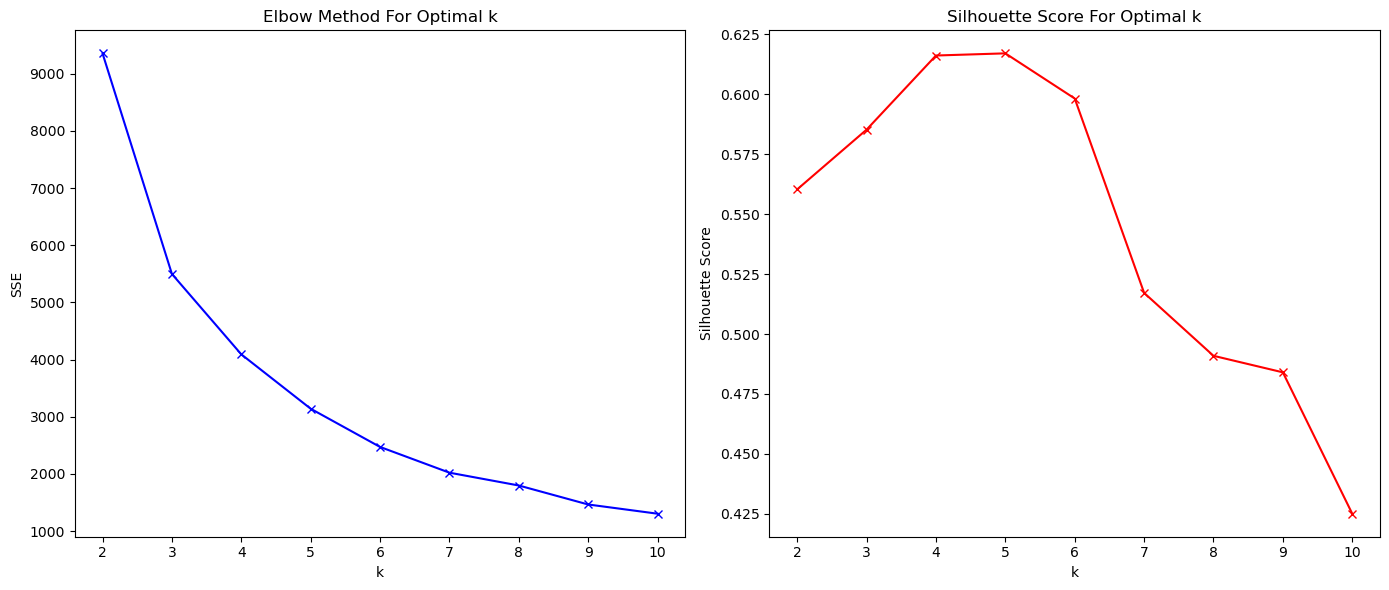

In [13]:
# Plot Elbow and Silhouette
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()

### Interpretation

- The elbow method suggests k=4 as optimal due to the bend, while the silhouette score favors k=3 for maximum cluster quality.

- A trade-off may be needed; k=3 offers better separation, while k=4 provides more detailed segmentation.

- The discrepancy highlights the importance of considering both metrics, with k=3 or k=4 being reasonable choices depending on business priorities.

- Final selection could involve domain expertise to balance interpretability and cluster distinctness.

In [14]:
# STEP 9: Apply K-Means Clustering
optimal_k = 4  # chosen based on the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


### Explanation 

- Applies KMeans with k=4 (assumed optimal from prior analysis).
- Adds Cluster column to rfm with labels 0-3 for each customer.
- Groups customers into 4 segments based on RFM values.


In [15]:
# STEP 10: Cluster Profiling
cluster_summary = rfm.groupby('Cluster').mean().round(2)
print("\nCluster Summary:\n", cluster_summary)


Cluster Summary:
          Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1359.05
1         248.08       1.55     480.62
2           7.38      82.54  127338.31
3          15.50      22.33   12709.09


### Interpretation (based on typical RFM clustering):
- Cluster 0: Recent, frequent, high spenders (e.g., loyal customers).
- Cluster 1: Less recent, low frequency, moderate spend (e.g., occasional buyers).
- Cluster 2: Moderately recent, frequent, decent spend (e.g., regular customers).
- Cluster 3: Very inactive, rare purchases, low spend (e.g., lapsed customers).
- Count shows cluster sizes; uneven distribution suggests varied segment sizes.

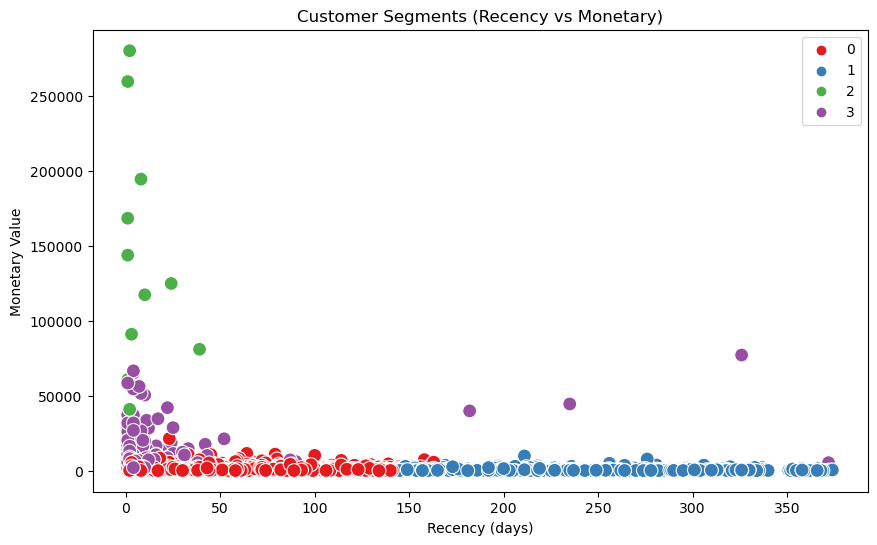

In [16]:
# STEP 11: Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1', s=100)
plt.title('Customer Segments (Recency vs Monetary)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()


### Interpretation:
- **Cluster 0 (Red):** Concentrated at low Recency (0-50 days) and low Monetary (<50,000), indicating recent but low-spending customers.
- **Cluster 1 (Blue):** Spread across high Recency (200-350 days) and low Monetary, suggesting inactive or lapsed customers with minimal spending.
- **Cluster 2 (Green):** Located at low Recency (0-50 days) with high Monetary (>100,000), representing loyal, high-value customers.
- **Cluster 3 (Purple):** Scattered with moderate to high Recency (100-300 days) and varying Monetary, indicating a mixed group of occasional or mid-tier spenders.

/Users/akashnileemborgohain/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akashnileemborgohain/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/akashnileemborgohain/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akashnileemborgohain/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore

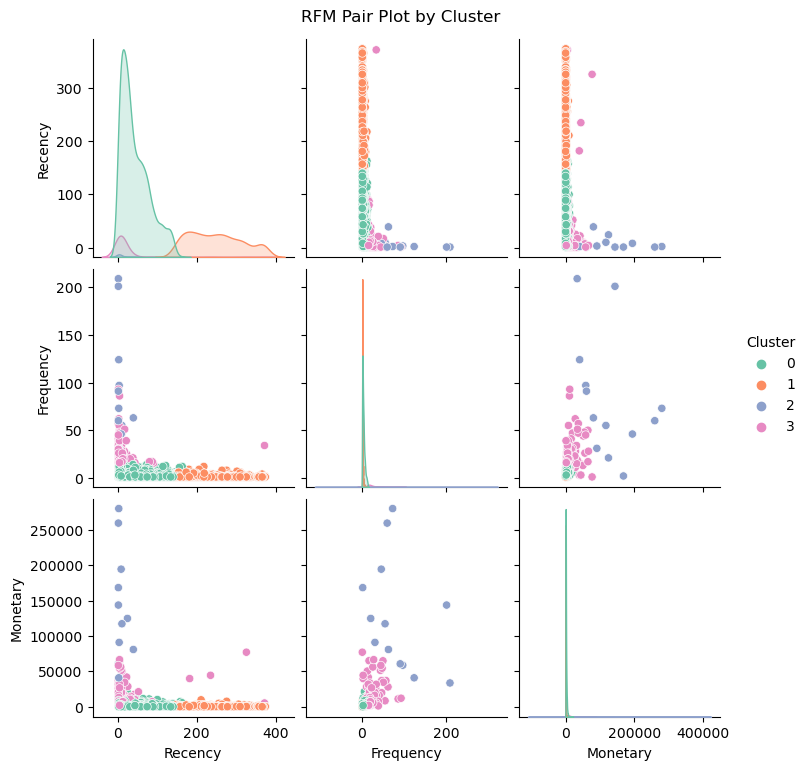

In [17]:
sns.pairplot(rfm.reset_index(), vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='Set2')
plt.suptitle('RFM Pair Plot by Cluster', y=1.02)
plt.show()


### Interpretation:
- **Recency Distribution:** Cluster 0 (green) dominates at low Recency (0-100 days), indicating recent customers, while Cluster 1 (orange) and Cluster 3 (pink) show higher Recency, suggesting inactive customers.
- **Frequency Distribution:** Cluster 0 and Cluster 2 (blue) have low to moderate Frequency (0-50), while Cluster 3 shows a peak at low Frequency, indicating less frequent purchases across clusters.
- **Monetary Distribution:** Cluster 2 has a few high Monetary values (>200,000), suggesting high-value customers, while Clusters 0 and 3 are concentrated at lower Monetary levels.
- **Scatter Relationships:** The Recency vs. Frequency and Recency vs. Monetary plots show Cluster 3 (pink) as more dispersed, indicating varied behavior, while Cluster 0 (green) is tightly clustered at low Recency and moderate Monetary.

### Conclusion and Implications

**Conclusion:**
- The analysis successfully segments 4,338 customers into 4 clusters using RFM metrics and KMeans clustering.
- Cluster 0 represents loyal, high-value customers, while Cluster 1 indicates lapsed customers needing re-engagement.
- The elbow method supports k=4 for detailed segmentation, while the silhouette score favors k=3 for optimal cohesion.

**Implications:**
- Targeted campaigns can focus on Cluster 0 for retention and upselling, and Cluster 1 for reactivation strategies.
- Resource allocation can prioritize high-value segments (Cluster 0) while monitoring mid-tier (Cluster 3) growth.
- The discrepancy between k=3 and k=4 suggests further validation with business goals.